# FPL Predictor EDA


Our project aims to predict Fantasy Premier League (FPL) points for individual players in upcoming gameweeks. The foundation of this prediction task is a rich time-series dataset detailing player performances and match contexts across multiple FPL seasons. Initially, our data for each player-gameweek instance included:

*   **Player Identifiers:** Such as `name` (player's name) and `element` (unique player ID).
*   **Match Context:** `fixture` (match ID), `team` (player's team ID), `opponent_team` (opponent's team ID), `was_home` (home/away status), `kickoff_time`, and `GW` or `round` (gameweek number).
*   **Player FPL Attributes:** `position` (GK, DEF, MID, FWD), `value` (FPL price), `selected` (ownership percentage), and transfer statistics (`transfers_in`, `transfers_out`, `transfers_balance`).
*   **Performance Outcomes (for that specific gameweek):** This is a crucial category. It includes raw statistics like `minutes` played, `goals_scored`, `assists`, `clean_sheets`, `bonus` points, `bps` (Bonus Points System), `ict_index` (Influence, Creativity, Threat), various "expected" stats (`xP`, `expected_goals`, `expected_assists`, etc.), and finally, our primary **target variable: `total_points`**.

It's vital to recognize that the raw performance outcomes are direct results of the match they describe. While essential for calculating the target variable (`total_points`) for historical data and for creating lagged features, they cannot be used as direct inputs when predicting points for a *future, unplayed* match, as this would constitute data leakage.

Think about adding previous years

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Read the CSV file into a pandas DataFrame
df = pd.read_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/merged_gw.csv")

df.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'starts', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [2]:
df.head()

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0,0.0,0,0,0,0,40,True,0,1
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,4,0.0,0,0,0,0,45,True,0,1
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,1,8.0,1,0,0,0,70,True,0,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0,0.0,0,0,0,0,40,True,0,1
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,2,17.0,2,0,0,0,55,True,0,1


In [3]:
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29725 entries, 0 to 29724
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        29725 non-null  object 
 1   position                    29725 non-null  object 
 2   team                        29725 non-null  object 
 3   xP                          29725 non-null  float64
 4   assists                     29725 non-null  int64  
 5   bonus                       29725 non-null  int64  
 6   bps                         29725 non-null  int64  
 7   clean_sheets                29725 non-null  int64  
 8   creativity                  29725 non-null  float64
 9   element                     29725 non-null  int64  
 10  expected_assists            29725 non-null  float64
 11  expected_goal_involvements  29725 non-null  float64
 12  expected_goals              29725 non-null  float64
 13  expected_goals

In [4]:
#turning bool into int
df['was_home'] = df['was_home'].astype(int)


print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Missing values per column:
Series([], dtype: int64)


### Duplicates

There is not a full duplicate but there is possibility of a gameweek repeating. To simplify we will get the mean score to show the average performance in two matches

In [5]:
dup_mask = df.duplicated(keep=False)

total_rows    = len(df)
total_dups    = dup_mask.sum()
pct_dups      = total_dups / total_rows * 100

print(f"Total rows:           {total_rows}")
print(f"Rows with duplicates: {total_dups}  ({pct_dups:.2f}%)")

Total rows:           29725
Rows with duplicates: 0  (0.00%)


In [6]:
dup_mask = df.duplicated(subset=["name","GW"], keep=False)

total_rows    = len(df)
total_dups    = dup_mask.sum()
pct_dups      = total_dups / total_rows * 100

print(f"Total rows:           {total_rows}")
print(f"Rows with duplicates: {total_dups}  ({pct_dups:.2f}%)")


Total rows:           29725
Rows with duplicates: 1966  (6.61%)


In [7]:
# we lose some information as important data like opposing team can't be calculated as a mean 
# however still a better method than dropping a row, acting like a match didn't happen
columns_to_keep = ["name","position","team","fixture", "kickoff_time", "opponent_team", "was_home"]

agg_map = {
    col: 'first' for col in columns_to_keep
}

for col in df.columns:
    if col not in agg_map:
        agg_map[col] = 'mean'

# Now group and aggregate
df = df.groupby(['name', 'GW'], as_index=False).agg(agg_map)

df.head()

,name,position,team,fixture,kickoff_time,opponent_team,was_home,xP,assists,bonus,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
0,Aaron Connolly,FWD,Brighton,4,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,...,1.0,4.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,1.0
1,Aaron Connolly,FWD,Brighton,20,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,...,4.0,1.0,0.0,0.0,-1441.0,0.0,1441.0,45.0,0.0,2.0
2,Aaron Connolly,FWD,Brighton,24,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,-719.0,0.0,719.0,45.0,0.0,3.0
3,Aaron Connolly,FWD,Brighton,33,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,...,1.0,3.0,0.0,0.0,-415.0,0.0,415.0,45.0,0.0,4.0
4,Aaron Connolly,FWD,Brighton,45,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,-359.0,0.0,359.0,45.0,0.0,5.0


### Distrubition of our target variable

As we can see from the distrubition, majority of gameweeks yield somewhere between 0 and 3 points with a heavy tail to the right as getting high points is possible with high goals and assist while getting low scores are extremely harder. 

Also there is a sharp drop off after 3–5 points as once you’ve scored 5 or 6 points you’re already outperforming most of the field. 

Keeping in mind that there are also an undeniable large amount of players that just stay on the bench (getting 0 points as a result) center of distrubition lying near 0 makes sense.

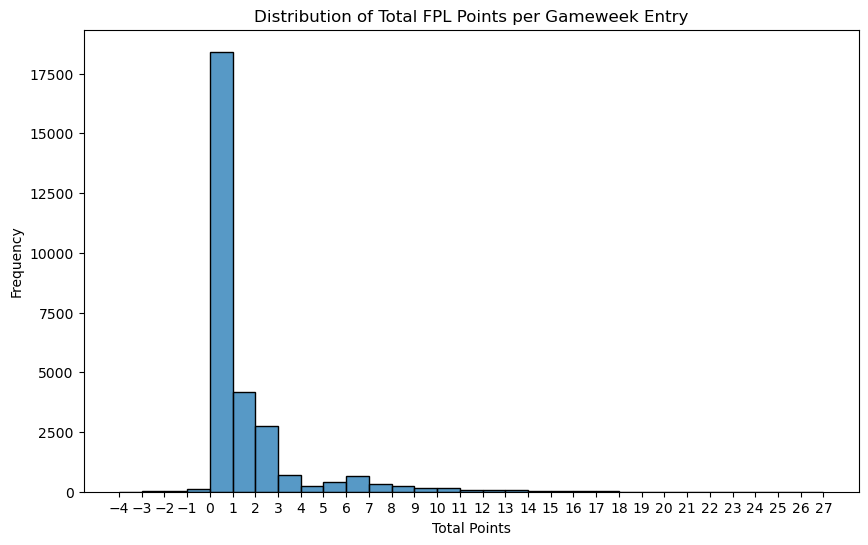


Value counts for total_points:
total_points
-4.0    0.000139
-3.0    0.000348
-2.0    0.001496
-1.0    0.003618
-0.5    0.000035
 0.0    0.638230
 0.5    0.002505
 1.0    0.143936
 1.5    0.001983
 2.0    0.094635
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['total_points'], bins=range(int(df['total_points'].min()), int(df['total_points'].max()) + 2), kde=False)
plt.title('Distribution of Total FPL Points per Gameweek Entry')
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.xticks(range(int(df['total_points'].min()), int(df['total_points'].max()) + 2, 1))
plt.show()

print(f"\nValue counts for total_points:\n{df['total_points'].value_counts(normalize=True).sort_index().head(10)}")

Important take aways

* Unimodal but skewed right: most point‐tallies cluster at the low end, with a long tail for the occasional outliers.

* Reflects event-driven scoring: small returns are common, big returns are rare.

* Outliers: High performances from high value players can be expected but not guaranteed while unexpected performances are one of the main entertainment factor of the game. Therefore, it might be a problem to expect the unexpected performance 

For our case since negative points happen so rarely we just give 0 points to signify they didn't earn any points. Also we can look at the log transform of the total points as it might be a way to prevent the harms of the skewness

In [9]:

df["total_points"] = df["total_points"].clip(lower=0)

# Apply log1p transformation: log(1 + x)
df["log1p_total_points"] = np.log1p(df["total_points"])

nan_count = df["log1p_total_points"].isnull().sum()
inf_count = np.isinf(df["log1p_total_points"]).sum()

if nan_count > 0 or inf_count > 0:
    print("WARNING: NaNs or Infs detected in log1p_total_points.")


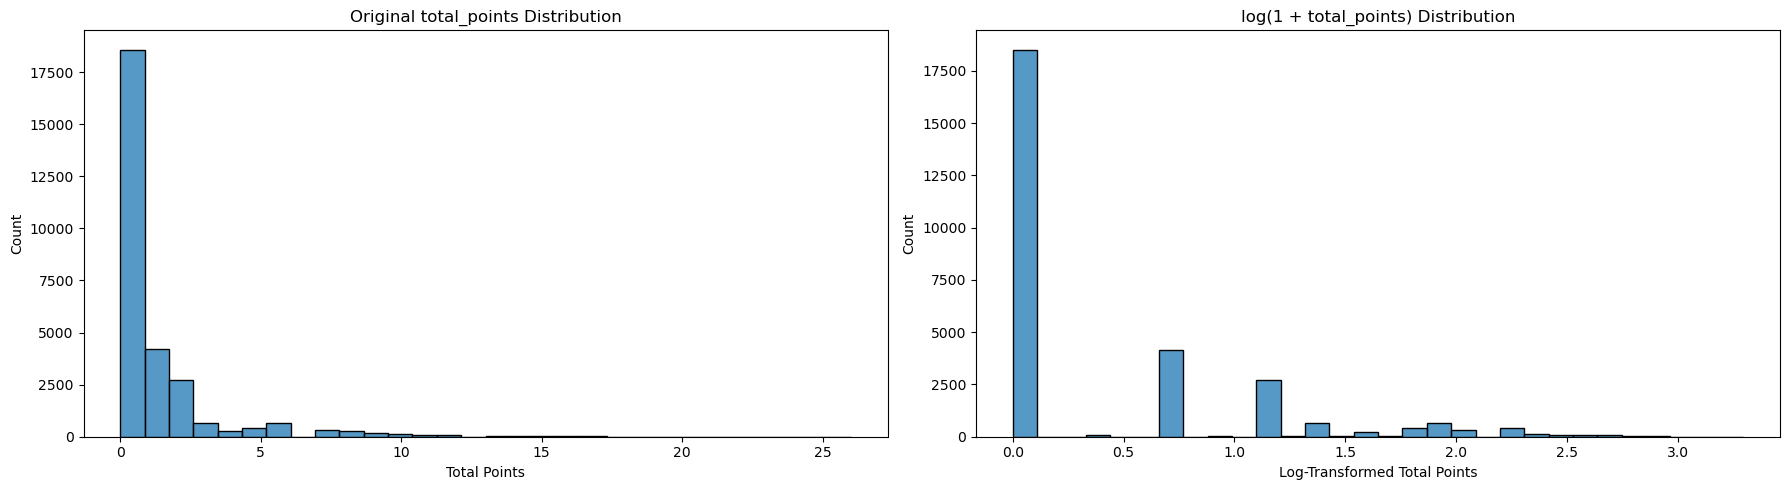

In [10]:
ig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(df["total_points"], ax=axes[0], kde=False, bins=30)
axes[0].set_title("Original total_points Distribution")
axes[0].set_xlabel("Total Points")

sns.histplot(df["log1p_total_points"], ax=axes[1], kde=False, bins=30)
axes[1].set_title("log(1 + total_points) Distribution")
axes[1].set_xlabel("Log-Transformed Total Points")

plt.tight_layout()
plt.show()

#problem in log comes from the fact that we are not dealing with continous points but integers

**Team and Opponent Strength Integration:** We incorporated external team-level data (`df_team`) which provided pre-match strength ratings for each team. For every player-gameweek instance, we merged:
    *   The strength of the player's own team.
    *   The strength of the opponent team.
    These features (`player_team_attack_strength`, `opponent_team_defence_strength`, etc.) quantify fixture difficulty.

In [11]:
df_team = pd.read_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/teams.csv")

df_team.head()

,code,draw,form,id,loss,name,played,points,position,short_name,...,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,NaN,1,0,Arsenal,0,0,0,ARS,...,NaN,False,0,1350,1365,1370,1370,1330,1360,1
1,7,0,NaN,2,0,Aston Villa,0,0,0,AVL,...,NaN,False,0,1160,1285,1140,1220,1180,1350,2
2,91,0,NaN,3,0,Bournemouth,0,0,0,BOU,...,NaN,False,0,1100,1100,1055,1130,1145,1075,127
3,94,0,NaN,4,0,Brentford,0,0,0,BRE,...,NaN,False,0,1100,1100,1110,1055,1090,1150,130
4,36,0,NaN,5,0,Brighton,0,0,0,BHA,...,NaN,False,0,1100,1210,1070,1180,1135,1240,131


In [12]:
team_id_map = df_team.set_index('name')['id'].to_dict()
df['team_id'] = df['team'].map(team_id_map)

df['team_id']

0        5
1        5
2        5
3        5
4        5
        ..
28737    7
28738    7
28739    7
28740    7
28741    7
Name: team_id, Length: 28742, dtype: int64

Fixtures

In [13]:
fixtures = pd.read_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/fixtures.csv")

fixtures.head()

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2367538,1,True,True,1,2023-08-11T19:00:00Z,90,False,True,13,3,6,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",5,2,93321
1,2367540,1,True,True,2,2023-08-12T12:00:00Z,90,False,True,16,1,1,2,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,5,93322
2,2367539,1,True,True,3,2023-08-12T14:00:00Z,90,False,True,19,1,3,1,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,93323
3,2367541,1,True,True,4,2023-08-12T14:00:00Z,90,False,True,12,1,5,4,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,3,93324
4,2367542,1,True,True,5,2023-08-12T14:00:00Z,90,False,True,10,1,9,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,2,93325


In [14]:
df = df.merge(fixtures[["id", "team_h", "team_a"]], left_on="fixture", right_on="id", how="left", suffixes=(None, "_fixture"))

strength_map = df_team.set_index("id")["strength"].to_dict()

# Add home and away strengths
df["home_strength"] = df["team_h"].map(strength_map)
df["away_strength"] = df["team_a"].map(strength_map)

In [15]:
df["opponent_id"] = df.apply(
    lambda row: row["team_a"] if row["team_id"] == row["team_h"] else row["team_h"], axis=1)

df["opponent_strength"] = df.apply(
    lambda row: row["away_strength"] if row["team_id"] == row["team_h"] else row["home_strength"], axis=1)

df["team_strength"] = df.apply(
    lambda row: row["home_strength"] if row["team_id"] == row["team_h"] else row["away_strength"], axis=1)

# cleanup
df = df.drop(columns=["id","opponent_id", "team_h", "team_a", "home_strength" , "away_strength"])

df.head()

,name,position,team,fixture,kickoff_time,opponent_team,was_home,xP,assists,bonus,...,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW,log1p_total_points,team_id,opponent_strength,team_strength
0,Aaron Connolly,FWD,Brighton,4,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,...,0.0,0.0,0.0,45.0,0.0,1.0,0.0,5,2,3
1,Aaron Connolly,FWD,Brighton,20,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,...,-1441.0,0.0,1441.0,45.0,0.0,2.0,0.0,5,3,3
2,Aaron Connolly,FWD,Brighton,24,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,...,-719.0,0.0,719.0,45.0,0.0,3.0,0.0,5,3,3
3,Aaron Connolly,FWD,Brighton,33,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,...,-415.0,0.0,415.0,45.0,0.0,4.0,0.0,5,3,3
4,Aaron Connolly,FWD,Brighton,45,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,...,-359.0,0.0,359.0,45.0,0.0,5.0,0.0,5,3,3


Turning categorical data into numerical (or getting rid of it)

We already got team ids and we disregard kickoff_time as it is irrelevant

In [16]:
df.dtypes[df.dtypes == object]

name            object
position        object
team            object
kickoff_time    object
dtype: object

Positions

In [17]:
pos_map = {
    "DEF": 1,
    "MID": 2,
    "FWD": 3,
    "GK":  4
}

df["position_id"] = df["position"].map(pos_map)

df.head()


,name,position,team,fixture,kickoff_time,opponent_team,was_home,xP,assists,bonus,...,transfers_in,transfers_out,value,yellow_cards,GW,log1p_total_points,team_id,opponent_strength,team_strength,position_id
0,Aaron Connolly,FWD,Brighton,4,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,...,0.0,0.0,45.0,0.0,1.0,0.0,5,2,3,3
1,Aaron Connolly,FWD,Brighton,20,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,...,0.0,1441.0,45.0,0.0,2.0,0.0,5,3,3,3
2,Aaron Connolly,FWD,Brighton,24,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,...,0.0,719.0,45.0,0.0,3.0,0.0,5,3,3,3
3,Aaron Connolly,FWD,Brighton,33,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,...,0.0,415.0,45.0,0.0,4.0,0.0,5,3,3,3
4,Aaron Connolly,FWD,Brighton,45,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,...,0.0,359.0,45.0,0.0,5.0,0.0,5,3,3,3


Player ids

In [18]:
df = df.rename(columns={'element': 'player_id'})

df[["name","player_id",]]



,name,player_id
0,Aaron Connolly,127.0
1,Aaron Connolly,127.0
2,Aaron Connolly,127.0
3,Aaron Connolly,127.0
4,Aaron Connolly,127.0
...,...,...
28737,Đorđe Petrović,687.0
28738,Đorđe Petrović,687.0
28739,Đorđe Petrović,687.0
28740,Đorđe Petrović,687.0


## Feature Selection

Before creating extensive lagged and rolling window features, let's perform some initial feature selection on the base cleaned data. This can help reduce noise and computational load for subsequent steps.


**Rationale for Pre-Engineering Selection:**
- **Reduce Noise:** Removing inherently uninformative or highly sparse base features can prevent noise propagation into many engineered features.
- **Computational Efficiency:** Fewer base features mean fewer lagged/rolled features to compute and store.
- **Simpler Interpretation:** Starting with a more focused set of base features can make the impact of engineered features easier to understand.

In [19]:
df_fe = df.copy()

df_fe.columns

Index(['name', 'position', 'team', 'fixture', 'kickoff_time', 'opponent_team',
       'was_home', 'xP', 'assists', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'player_id', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'starts',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'yellow_cards', 'GW', 'log1p_total_points', 'team_id',
       'opponent_strength', 'team_strength', 'position_id'],
      dtype='object')

#### Sparsity 

Remove features that have a very high percentage of zero or constant values, as they might not provide much information for many instances. For this we select an extremely selective treshold. Here we might lose some information however it is negligible 


In [20]:
sparsity_threshold_pct = 0.01
min_non_zero_entries = (sparsity_threshold_pct) * len(df)

features_to_drop_sparsity = []
for col in df_fe.columns:    
    non_zero_count = np.count_nonzero(df_fe[col])
    if non_zero_count < min_non_zero_entries:
        features_to_drop_sparsity.append(col)
        print(f"  - Dropping '{col}' (sparsity: {non_zero_count / len(df_fe) * 100:.2f}% non-zero)")



df_fe = df_fe.drop(columns=features_to_drop_sparsity)

  - Dropping 'own_goals' (sparsity: 0.17% non-zero)
  - Dropping 'penalties_missed' (sparsity: 0.04% non-zero)
  - Dropping 'penalties_saved' (sparsity: 0.03% non-zero)
  - Dropping 'red_cards' (sparsity: 0.20% non-zero)


#### Correlation 

Identify and remove one feature from a pair of highly correlated features. This helps reduce multicollinearity. We use Spearman correlation as it's robust to outliers.


In [21]:
int_df = df_fe.select_dtypes(include=["int","float"])
int_df.drop(columns=["total_points"],inplace=True) # as we only want to look at the correlation of features

corr_matrix = int_df.corr(method="spearman").abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlation_threshold = 0.90



for column in upper.columns:
        for index in upper.index:
            if upper.loc[index, column] > correlation_threshold:
                print(f"  - High correlation ({upper.loc[index, column]:.2f}) between '{column}' and '{index}'.")
                    

  - High correlation (0.90) between 'expected_goal_involvements' and 'creativity'.
  - High correlation (0.93) between 'expected_goal_involvements' and 'expected_assists'.
  - High correlation (0.92) between 'ict_index' and 'creativity'.
  - High correlation (0.91) between 'ict_index' and 'expected_goals_conceded'.
  - High correlation (0.92) between 'influence' and 'bps'.
  - High correlation (0.90) between 'influence' and 'expected_goals_conceded'.
  - High correlation (0.96) between 'influence' and 'ict_index'.
  - High correlation (0.90) between 'minutes' and 'bps'.
  - High correlation (0.96) between 'minutes' and 'expected_goals_conceded'.
  - High correlation (0.95) between 'minutes' and 'ict_index'.
  - High correlation (0.94) between 'minutes' and 'influence'.
  - High correlation (1.00) between 'round' and 'fixture'.
  - High correlation (1.00) between 'GW' and 'fixture'.
  - High correlation (1.00) between 'GW' and 'round'.
  - High correlation (0.91) between 'log1p_total_po

In [22]:
# Looking at the correlations, we also use real world insight to select the ones that can be dropped
# we drop influence and creativity as ict index includes them
# expected goals conceded can be thought of an independent stat but too many high correlations claims that it should be dropped

features_to_drop_corr = ["fixture", "round", "influence", "creativity", "expected_goals_conceded"] 

df_fe = df_fe.drop(columns=features_to_drop_corr)

### Feature Engineering 

Raw, single-gameweek statistics provide a snapshot but often lack the context needed for robust prediction. To enhance our dataset's predictive capability, we performed extensive feature engineering, focusing on capturing player form, fixture difficulty, and temporal dynamics:

1.  **Lagged Player Performance:** To model player's recent form and momentum, we created lagged features for key performance metrics (e.g., `goals_scored_lag_1`, `minutes_lag_1`, `total_points_lag_3`). These represent a player's stats from the immediately preceding gameweeks.

2.  **Rolling Aggregates:** Beyond direct lags, we calculated rolling window statistics (e.g., `ict_index_roll_mean3_lag1`, `total_points_roll_sum5_lag1`). These features smooth out short-term variance and provide a more stable view of recent performance over a defined window (e.g., last 3 or 5 gameweeks, excluding the current one).

All newly created lagged and rolling features had `NaN` values for the initial gameweeks of a player's history (or season). These were typically filled with `0`, assuming no prior data implies zero prior contribution for performance metrics.

In [23]:
# Creates lagged features and rolling window features for a target column. 
# We can't access to some data in t so we get t-1 or even further back in time.
def create_lagged_features(data, group_cols, target_col, lags, window_size=None):
 
    data = data.copy()
    for lag in lags:
        new_col_name = f'{target_col}_lag_{lag}'
        data[new_col_name] = data.groupby(group_cols)[target_col].shift(lag)
        data[new_col_name] = data[new_col_name].fillna(0)

    if window_size:

        rolling_col_name = f'{target_col}_roll_{"mean"}{window_size}_lag1'
        data[rolling_col_name] = data.groupby(group_cols)[target_col].shift(1).fillna(0).rolling(window=window_size, min_periods=1).mean()



    return data


In [24]:
lagged_features = ["assists", "bonus", "bps", "clean_sheets", "creativity", "goals_conceded", 
                           "goals_scored", "ict_index", "influence", "minutes", "own_goals", "penalties_missed", 
                           "penalties_saved", "red_cards", "saves", "starts", "threat", "yellow_cards", "total_points", #not log transform because correlated
                           "xP", "expected_assists", "expected_goal_involvements", "expected_goals", "expected_goals_conceded", 
                           "value", "selected", "transfers_balance", "transfers_in", "transfers_out", "team_a_score", "team_h_score"]  



# we lag also total points as previous games total point can be important information.

group_by_cols = ['name']



for col in lagged_features:
    # there are features that we dropped in feature selection so we add this step
    if col in df_fe.columns:
        df_fe = create_lagged_features(df_fe, group_cols=group_by_cols, target_col=col, lags=[1,2])

rolling_windows = [3,5] #can be changed
for col in lagged_features:
    if col in df_fe.columns:
        for window in rolling_windows:
            df_fe = create_lagged_features(df_fe, group_cols=group_by_cols, target_col=col, lags=[], window_size=window)



print("\nDataFrame with lagged player features (sample):")

# Show an example for one player
df_fe[df_fe['name'] == "Mohamed Salah"][['GW', 'total_points'] + [col for col in df_fe.columns if 'total_points_lag' in col or 'total_points_roll' in col]].head(10)


DataFrame with lagged player features (sample):


,GW,total_points,total_points_lag_1,total_points_lag_2,total_points_roll_mean3_lag1,total_points_roll_mean5_lag1
20528,1.0,5.0,0.0,0.0,0.000000,0.0
20529,2.0,5.0,5.0,0.0,1.666667,1.0
20530,3.0,5.0,5.0,5.0,3.333333,2.0
20531,4.0,8.0,5.0,5.0,5.000000,3.0
20532,5.0,10.0,8.0,5.0,6.000000,4.6
20533,6.0,10.0,10.0,8.0,7.666667,6.6
20534,7.0,1.0,10.0,10.0,9.333333,7.6
20535,8.0,15.0,1.0,10.0,7.000000,6.8
20536,9.0,16.0,15.0,1.0,8.666667,8.8
20537,10.0,8.0,16.0,15.0,10.666667,10.4


### Saving the processed data

In [25]:
df_fe.head()

,name,position,team,kickoff_time,opponent_team,was_home,xP,assists,bonus,bps,...,transfers_balance_roll_mean3_lag1,transfers_balance_roll_mean5_lag1,transfers_in_roll_mean3_lag1,transfers_in_roll_mean5_lag1,transfers_out_roll_mean3_lag1,transfers_out_roll_mean5_lag1,team_a_score_roll_mean3_lag1,team_a_score_roll_mean5_lag1,team_h_score_roll_mean3_lag1,team_h_score_roll_mean5_lag1
0,Aaron Connolly,FWD,Brighton,2023-08-12T14:00:00Z,12,1,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Aaron Connolly,FWD,Brighton,2023-08-19T14:00:00Z,20,0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.500000,0.500000,2.000000,2.000000
2,Aaron Connolly,FWD,Brighton,2023-08-26T16:30:00Z,19,1,0.0,0.0,0.0,0.0,...,-480.333333,-480.333333,0.0,0.0,480.333333,480.333333,1.666667,1.666667,1.666667,1.666667
3,Aaron Connolly,FWD,Brighton,2023-09-02T16:30:00Z,15,1,0.0,0.0,0.0,0.0,...,-720.000000,-540.000000,0.0,0.0,720.000000,540.000000,2.666667,2.000000,2.000000,1.500000
4,Aaron Connolly,FWD,Brighton,2023-09-16T14:00:00Z,14,0,0.0,0.0,0.0,0.0,...,-858.333333,-515.000000,0.0,0.0,858.333333,515.000000,2.666667,1.800000,1.666667,1.800000


In [26]:
df_fe.to_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/processed_data.csv", index=False)

### Getting data of Mohamed Salah for later testing

In [27]:
df_salah = df_fe[df_fe["name"] == "Mohamed Salah"]

df_salah.head()

,name,position,team,kickoff_time,opponent_team,was_home,xP,assists,bonus,bps,...,transfers_balance_roll_mean3_lag1,transfers_balance_roll_mean5_lag1,transfers_in_roll_mean3_lag1,transfers_in_roll_mean5_lag1,transfers_out_roll_mean3_lag1,transfers_out_roll_mean5_lag1,team_a_score_roll_mean3_lag1,team_a_score_roll_mean5_lag1,team_h_score_roll_mean3_lag1,team_h_score_roll_mean5_lag1
20528,Mohamed Salah,MID,Liverpool,2023-08-13T15:30:00Z,7,0,4.5,1.0,0.0,15.0,...,-10.666667,-28.2,27.333333,24.6,38.000000,52.8,0.333333,1.0,1.000000,1.5
20529,Mohamed Salah,MID,Liverpool,2023-08-19T14:00:00Z,3,1,5.5,0.0,0.0,15.0,...,0.666667,-17.2,20.666667,19.6,20.000000,36.8,0.666667,1.0,0.333333,1.2
20530,Mohamed Salah,MID,Liverpool,2023-08-27T15:30:00Z,15,0,5.0,1.0,0.0,19.0,...,54354.666667,32606.4,70539.000000,42339.8,16184.333333,9733.4,0.666667,0.6,1.333333,1.4
20531,Mohamed Salah,MID,Liverpool,2023-09-03T13:00:00Z,2,1,6.3,0.0,0.0,26.0,...,-22077.666667,-13246.2,103451.666667,62083.4,125529.333333,75329.6,1.333333,1.0,1.666667,1.0
20532,Mohamed Salah,MID,Liverpool,2023-09-16T11:30:00Z,20,0,8.2,2.0,2.0,35.0,...,-62883.000000,-37729.8,128322.333333,76993.4,191205.333333,114723.2,1.000000,0.8,2.333333,1.6


In [28]:
df_salah.to_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/salah.csv", index=False)

## Getting the data of "active" players

To get rid of the skewness and the domination of 0-1 points in our data, we select only the players averaged more than 4 points throughout the seasons as an important evaluation metric

In [29]:
player_total_points = df_fe.groupby('name')['total_points'].mean()

threshold = 4

# identify players who meet the threshold
active_player_names = player_total_points[player_total_points >= threshold].index.tolist()

original_player_count = df_fe['name'].nunique()
active_player_count = len(active_player_names)

# filter the DataFrame to keep only these active players
df_active_players= df_fe[df_fe['name'].isin(active_player_names)].copy()
    
df_active_players

,name,position,team,kickoff_time,opponent_team,was_home,xP,assists,bonus,bps,...,transfers_balance_roll_mean3_lag1,transfers_balance_roll_mean5_lag1,transfers_in_roll_mean3_lag1,transfers_in_roll_mean5_lag1,transfers_out_roll_mean3_lag1,transfers_out_roll_mean5_lag1,team_a_score_roll_mean3_lag1,team_a_score_roll_mean5_lag1,team_h_score_roll_mean3_lag1,team_h_score_roll_mean5_lag1
996,Alexander Isak,FWD,Newcastle,2023-08-12T16:30:00Z,2,1,3.0,0.0,3.0,51.0,...,-0.333333,-0.2,0.000000,0.0,0.333333,0.2,0.500000,0.9,1.833333,2.1
997,Alexander Isak,FWD,Newcastle,2023-08-19T19:00:00Z,13,0,7.0,0.0,0.0,7.0,...,0.000000,-0.2,0.000000,0.0,0.000000,0.2,0.833333,0.7,2.166667,2.3
998,Alexander Isak,FWD,Newcastle,2023-08-27T15:30:00Z,11,1,5.7,0.0,0.0,5.0,...,144513.333333,86707.8,169439.333333,101663.6,24926.000000,14955.8,0.333333,0.5,2.000000,2.3
999,Alexander Isak,FWD,Newcastle,2023-09-02T16:30:00Z,5,0,5.3,0.0,0.0,7.0,...,236620.000000,141972.0,305515.333333,183309.2,68895.333333,41337.2,1.000000,0.9,2.333333,1.7
1000,Alexander Isak,FWD,Newcastle,2023-09-16T16:30:00Z,4,1,1.8,0.0,0.0,0.0,...,248692.666667,149215.6,377327.000000,226396.2,128634.333333,77180.6,1.000000,0.8,1.666667,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28075,William Saliba,DEF,Arsenal,2024-04-20T18:30:00Z,20,0,13.4,0.0,1.0,27.5,...,52578.333333,33175.6,78241.666667,76178.0,25663.333333,43002.4,1.666667,1.2,0.666667,0.8
28076,William Saliba,DEF,Arsenal,2024-04-28T13:00:00Z,18,0,5.2,0.0,0.0,14.0,...,50925.000000,30081.6,82014.333333,74354.8,31089.333333,44273.2,2.000000,1.2,0.833333,0.9
28077,William Saliba,DEF,Arsenal,2024-05-04T11:30:00Z,3,1,5.4,0.0,0.0,26.0,...,-52.333333,24050.6,66846.666667,73439.2,66899.000000,49388.6,2.000000,1.8,1.500000,1.3
28078,William Saliba,DEF,Arsenal,2024-05-12T15:30:00Z,14,0,7.0,0.0,3.0,30.0,...,-16803.333333,10540.6,58267.666667,65274.6,75071.000000,54734.0,1.333333,1.8,2.500000,1.5


In [30]:
df_active_players.to_csv("C:/Users/asus/OneDrive/Desktop/projects/AI_project/data/active_players.csv", index=False)